In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, interpolate, signal, stats

from pynwb import NWBHDF5IO

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
sigalpha = 0.05
c_vermillion = (213/255, 94/255, 0/255)
c_bgreen = (0/255, 158/255, 115/255)
c_skyblue = (86/255, 180/255, 233/255)

### Load NWB file

In [6]:
## Open the file in read mode "r" ##
io = NWBHDF5IO(r"T:\zap-n-zip\eLife_manuscript_NWBfiles\000458\sub-571619\sub-571619_ses-20210319_behavior+ecephys.nwb", mode="r")
nwbfile = io.read()

In [7]:
nwbfile

root pynwb.file.NWBFile at 0x2354638733384
Fields:
  acquisition: {
    ElectricalSeriesEEG <class 'pynwb.ecephys.ElectricalSeries'>,
    LFPprobeB <class 'pynwb.ecephys.LFP'>,
    LFPprobeC <class 'pynwb.ecephys.LFP'>,
    LFPprobeF <class 'pynwb.ecephys.LFP'>
  }
  devices: {
    EEG array <class 'pynwb.device.Device'>,
    probeB <class 'pynwb.device.Device'>,
    probeC <class 'pynwb.device.Device'>,
    probeF <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    EEG array <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeB <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeC <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeF <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: in vivo electrophysiology in a head-fixed mouse during cortical electrical microstimulation
  experimenter: ['Claar, Leslie D' 'Rembado, Irene' 'Kuyat, Jacqulyn R' 'Russo

### Load trial times as dataframe

In [8]:
trials_df = nwbfile.trials.to_dataframe()
trials_df.head()

,start_time,stop_time,stimulus_type,stimulus_description,estim_current,estim_target_region,estim_target_depth,behavioral_epoch,is_running,is_valid
id,,,,,,,,,,
0,319.16422,319.16462,electrical,biphasic,40,MOs,superficial,awake,True,True
1,322.69724,322.69764,electrical,biphasic,20,MOs,superficial,awake,True,True
2,326.75887,326.75927,electrical,biphasic,40,MOs,superficial,awake,True,True
3,331.14116,331.14156,electrical,biphasic,60,MOs,superficial,awake,False,True
4,335.31077,335.31117,electrical,biphasic,60,MOs,superficial,awake,True,True


In [9]:
stim_currents = np.unique(trials_df['estim_current'].values)
print(stim_currents)

['20' '40' '60']


In [10]:
plstate = 'awake'
stim_onsets = trials_df[
    (trials_df['stimulus_type'] == 'electrical') &
    (trials_df['estim_current'] == '40') &
    (trials_df['estim_target_depth'] == 'deep') &
    (trials_df['behavioral_epoch'] == plstate) &
    (trials_df['is_valid'] == True)
]['start_time'].values
print(len(stim_onsets))

118


### Load EEG traces and metadata (for bad chs)

In [11]:
electrodes_df = nwbfile.electrodes.to_dataframe()

In [12]:
EEG_df = electrodes_df[electrodes_df['group_name'] == 'EEG array']
print(len(EEG_df))
EEG_df.head()

30


,location,group,group_name,is_data_valid,probe_vertical_position,probe_horizontal_position,x,y,z,reference
id,,,,,,,,,,
0,VISl,EEG array pynwb.ecephys.ElectrodeGroup at 0x26...,EEG array,True,-1,-1,377.0,58.0,82.0,"stainless steel skull screw, left CB"
1,VISp,EEG array pynwb.ecephys.ElectrodeGroup at 0x26...,EEG array,True,-1,-1,377.0,24.0,141.0,"stainless steel skull screw, left CB"
2,RSPagl,EEG array pynwb.ecephys.ElectrodeGroup at 0x26...,EEG array,False,-1,-1,377.0,20.0,188.0,"stainless steel skull screw, left CB"
3,VISal,EEG array pynwb.ecephys.ElectrodeGroup at 0x26...,EEG array,False,-1,-1,333.0,47.0,79.0,"stainless steel skull screw, left CB"
4,VISp,EEG array pynwb.ecephys.ElectrodeGroup at 0x26...,EEG array,False,-1,-1,333.0,25.0,119.0,"stainless steel skull screw, left CB"


In [13]:
EEGchs = EEG_df.index.values
good_chs = EEG_df[EEG_df['is_data_valid'] == True].index.values
bad_chs = EEG_df[EEG_df['is_data_valid'] == False].index.values
print(bad_chs)

[ 2  3  4  5  8 13]


In [14]:
EEG_raw = nwbfile.acquisition['ElectricalSeriesEEG'].data[:] * nwbfile.acquisition['ElectricalSeriesEEG'].conversion * 1E6
EEG_ts = nwbfile.acquisition['ElectricalSeriesEEG'].timestamps[:]

In [15]:
EEG_raw.shape

(19863552, 30)

In [16]:
EEG_samplerate = int(np.mean(1 / np.diff(EEG_ts[0:10])))

Mask estim artifact

In [17]:
mask_samples = int(0.002 * EEG_samplerate)
for etime in trials_df.loc[trials_df['stimulus_type'] == 'electrical', 'start_time'].to_numpy():
    val = find_nearest_ind(EEG_ts, etime) - 2
    EEG_raw[val:val+mask_samples, :] = EEG_raw[val:val-mask_samples:-1, :]

Apply high-pass filter

In [18]:
hpb, hpa = signal.butter(3, 0.1/(EEG_samplerate/2), btype='highpass')
EEG_raw = signal.filtfilt(hpb, hpa, EEG_raw, axis=0)

### Get evoked traces

In [19]:
event_traces, event_ts = get_evoked_traces(EEG_raw, EEG_ts, stim_onsets, 2., 2., EEG_samplerate)
print(event_traces.shape)

(10000, 30, 118)


Apply low-pass filter

In [20]:
lpb, lpa = signal.butter(3, 100/(EEG_samplerate/2), btype='lowpass')
event_traces = signal.filtfilt(lpb, lpa, event_traces, axis=0)

Apply common-average reference montage

In [21]:
event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]

### Plot array shape ERP

<IPython.core.display.Javascript object>


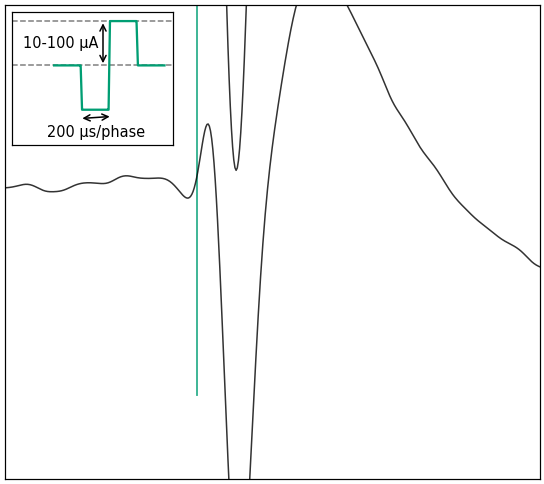

Text(0.1, -1.35, '200 μs/phase')

In [22]:
plwin = [-0.2, 0.8]
xmult = 1.2
ymult = 150 # 250 for VEPs: 100
bregma_ann = {'xycoords': 'data', 'textcoords': 'data', 'arrowprops': dict(arrowstyle='<-', lw=1)}

## Create stim wave for inset ##
xvals = np.arange(-0.2, 0.6, 0.01)
yvals = np.zeros_like(xvals)
yvals[np.nonzero((xvals > 0) & (xvals <= 0.2))[0]] = -1
yvals[np.nonzero((xvals > 0.2) & (xvals <= 0.4))[0]] = 1



fig, ax = plt.subplots(figsize=(4.5, 4), constrained_layout=True)


traces = np.mean(event_traces, axis=2)
pinds = np.nonzero((event_ts >= plwin[0]) & (event_ts <= plwin[1]))[0]

for chi in range(traces.shape[1]):
    if chi in good_chs:
        chcolor = 'k'
    else:
        chcolor = 'darkgray'
    if chi == 0:
        llabel = plstate
    else:
        llabel = None
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color=c_bgreen, linewidth=1.2, alpha=0.8, label=None)
    ax.plot(
        event_ts[pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        color=chcolor, linewidth=1.0, alpha=0.8, label=llabel
    )

    if chi == 0:
        mx = event_ts[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * 0.85
        my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## Scale bar ##
x_len = .5 # x scale bar length in s
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx+x_len/2,my-y_len*2.25), xycoords='data', ha='center', va='bottom')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx-x_len/3,my-y_len/2), xycoords='data', ha='right', va='center')

## Add symbols for stim, NPXs, and bregma ##
ax.annotate('A', xy=(0,0), xytext=(0,70), ha='center', va='bottom', **bregma_ann)
ax.annotate('P', xy=(0,0), xytext=(0,-70), ha='center', va='top', **bregma_ann)
ax.annotate('L', xy=(0,0), xytext=(-0.8,0), ha='left', va='center', **bregma_ann)
ax.annotate('R', xy=(0,0), xytext=(0.8,0), ha='right', va='center', **bregma_ann)
# ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='X', color='b', linestyle='none')
ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='o', markersize=12, color=c_skyblue, linestyle='none', alpha=0.8)
ax.plot([-1.7], [250], marker='*', color=c_vermillion, markersize=8) #, label='stim')
ax.set_xlim([-7, 6])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Add stim inset ##
axins = inset_axes(ax, width="30%", height="28%", loc=2)
axins.axhline(0, color='gray', linewidth=1, linestyle='dashed')
axins.axhline(1, color='gray', linewidth=1, linestyle='dashed')
axins.plot(xvals, yvals, color=c_bgreen, linewidth=1.5)
axins.set_xlim([-0.5, 0.65])
axins.set_ylim([-1.8, 1.2])
axins.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axins.annotate('', xy=(0.15, -0.02), xytext=(0.15, 1.02), arrowprops=dict(arrowstyle='<->'))
axins.annotate('10-100 \u03bcA', xy=(0.12, 0.5), ha='right', va='center', annotation_clip=False, fontsize=9.5)
axins.annotate('', xy=(-0.02, -1.2), xytext=(0.22, -1.15), arrowprops=dict(arrowstyle='<->'))
axins.annotate('200 \u03bcs/phase', xy=(0.1, -1.35), ha='center', va='top', annotation_clip=False, fontsize=9.5)

### Load units table

In [8]:
all_units_df = nwbfile.units.to_dataframe()

In [9]:
all_units_df.head()

,location,x,y,z,isi_violations,amplitude_cutoff,presence_ratio,waveform_duration,spike_times,electrodes,electrode_group,waveform_mean
id,,,,,,,,,,,,
0,VPL,257.0,155.0,167.0,0.147870,0.001195,0.93,0.439531,"[12.8981135933318, 13.47477914267256, 14.00051...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,"[0.0, -2.074605e-06, -3.444869999999999e-06, -..."
1,VPL,257.0,154.0,167.0,0.198153,0.007205,0.83,0.398325,"[12.902246918656147, 12.905913578218588, 13.48...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,"[0.0, -1.334775000000001e-06, -2.432235e-06, -..."
2,VPL,257.0,155.0,167.0,0.095500,0.025247,0.63,0.494472,"[12.878946963801354, 13.264412883603654, 13.80...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,"[0.0, -1.611674999999999e-06, -3.8032800000000..."
3,VPL,257.0,154.0,167.0,0.443622,0.098971,0.51,0.549414,"[12.907213575699643, 16.50693993433788, 17.231...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,"[0.0, -5.317649999999995e-06, -1.0561395000000..."
4,VPL,257.0,155.0,167.0,0.394805,0.030374,0.99,0.425796,"[12.901713586356436, 12.907846907805833, 13.26...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,"[0.0, 1.3162500000000322e-07, 1.10915999999999..."


In [10]:
all_units_df['electrodes'].iloc[0]

,location,group,group_name,is_data_valid,probe_vertical_position,probe_horizontal_position,x,y,z,reference
id,,,,,,,,,,
31,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,20,11,257.0,155.0,167.0,tip reference configuration


In [13]:
nwbfile.units.electrodes.to_dataframe().head()

,location,group,group_name,is_data_valid,probe_vertical_position,probe_horizontal_position,x,y,z,reference
id,,,,,,,,,,
31,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,20,11,257.0,155.0,167.0,tip reference configuration
33,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,40,27,257.0,154.0,167.0,tip reference configuration
31,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,20,11,257.0,155.0,167.0,tip reference configuration
33,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,40,27,257.0,154.0,167.0,tip reference configuration
31,VPL,probeB pynwb.ecephys.ElectrodeGroup at 0x23546...,probeB,True,20,11,257.0,155.0,167.0,tip reference configuration


In [17]:
nwbfile.units.spike_times_index[0]

array([  12.89811359,   13.47477914,   14.00051146, ..., 7884.3131407 ,
       7899.5339429 , 7951.91114126])